In [1]:
%load_ext autoreload
%autoreload 2

# Multidimensional datasets (ions)

Sometimes we want to extract complex data, this is a tutorial on how to do that with [xarray](https://docs.xarray.dev)

First, we define where to get the data from.

In [2]:
from duqtools.api import ImasHandle

paths = (
    'g2vazizi/jet/94875/8000',
    'g2vazizi/jet/94875/8001',
    'g2vazizi/jet/94875/8002',
)
handles = [ImasHandle.from_string(p) for p in paths]

## Defining variables

Then we must define the relations between the data. This is done via the `Variable` model.

ion_temperature is not in the default list of [variables](https://duqtools.readthedocs.io/en/latest/variables/), so we must define it. Note that we create an extra dimension with `*` to select all the ions.

The other variables are defined by `duqtools`, so we can pass them as string.

In [3]:
from duqtools.api import Variable

variables = (Variable(name='ion_temperature',
                      ids='core_profiles',
                      path='profiles_1d/*/ion/*/temperature',
                      dims=['time', 'ion', '$rho_tor_norm']), 't_i_ave',
             'rho_tor_norm', 'time')

## Loading the data

Load the data using the `get_variables()` method.

In [4]:
datasets = tuple(handle.get_variables(variables) for handle in handles)
datasets[0]

<xarray.Dataset>
Dimensions:          (time: 101, ion: 3, rho_tor_norm: 100)
Coordinates:
  * time             (time) float64 48.35 48.36 48.36 48.37 ... 48.99 48.99 49.0
  * rho_tor_norm     (rho_tor_norm) float64 0.005025 0.01508 ... 0.9899 1.0
Dimensions without coordinates: ion
Data variables:
    ion_temperature  (time, ion, rho_tor_norm) float64 9.499e+03 ... 643.8
    t_i_ave          (time, rho_tor_norm) float64 9.499e+03 9.493e+03 ... 643.8

## Time Standardizing

Sometimes we have datasets with various starting times, but we want to compare them anyway
for this you can use the `standardize_time()` function, which is an in-place operation:

In [5]:
from duqtools.ids import standardize_time

for ds in datasets:
    standardize_time(ds, start=0.1)

## Grid and time rebasing

We can interpolate all datasets to the same reference grid and time using `standardize_grid_and_time()`.

In [6]:
from duqtools.api import standardize_grid_and_time

datasets = standardize_grid_and_time(
    datasets,
    grid_var='rho_tor_norm',
    time_var='time',
    reference_dataset=0,
)

## Data concatenation

Finally, we can concatenate along the run dimension. We set the run coordinates to the name of the data so they can be re-used later.

In [7]:
import xarray as xr

dataset = xr.concat(datasets, 'run')
dataset['run'] = list(paths)

Now we have the data in a nicely structured xarray dataset.

In [8]:
dataset

<xarray.Dataset>
Dimensions:          (run: 3, time: 101, ion: 3, rho_tor_norm: 100)
Coordinates:
  * rho_tor_norm     (rho_tor_norm) float64 0.005025 0.01508 ... 0.9899 1.0
  * time             (time) float64 0.1 0.1077 0.1149 ... 0.7389 0.7449 0.75
  * run              (run) <U23 'g2vazizi/jet/94875/8000' ... 'g2vazizi/jet/9...
Dimensions without coordinates: ion
Data variables:
    ion_temperature  (run, time, ion, rho_tor_norm) float64 9.499e+03 ... 760.9
    t_i_ave          (run, time, rho_tor_norm) float64 9.499e+03 ... 760.9

## Plotting

Now that we have standardized and rebased the grid and time coordinates, plotting and other operations on the data becomes straightforward. 

`xarray` has some built-in functionality to make plots using [matplotlib](https://matplotlib.org).

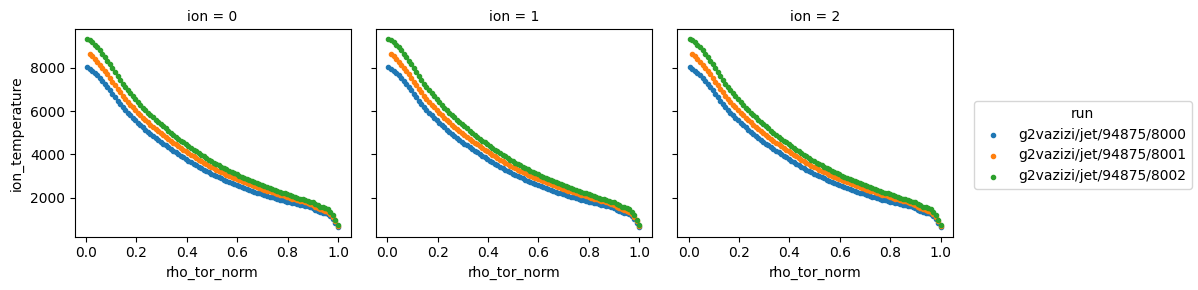

In [9]:
dataset.isel(time=50).plot.scatter('rho_tor_norm',
                                   'ion_temperature',
                                   hue='run',
                                   col='ion',
                                   marker='.')

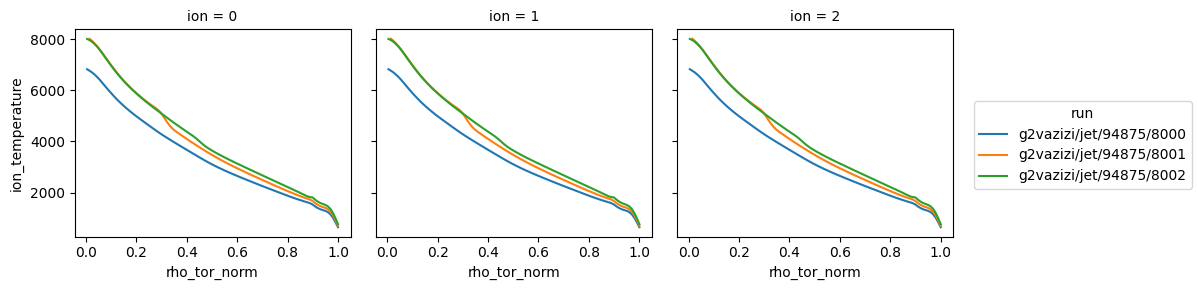

In [10]:
dataset['ion_temperature'].isel(time=10).plot.line(
    x='rho_tor_norm',
    hue='run',
    col='ion',
)

*Duqtools* has some built-in plots as well, using [altair](https://altair-viz.github.io/), that are designed with larger data sets and interactivity in mind.

In [11]:
from duqtools.api import alt_line_chart

chart = alt_line_chart(dataset.isel(time=[0, 1, 2, 3]),
                       x='rho_tor_norm',
                       y='ion_temperature')
chart

alt.LayerChart(...)

alternatively, the data can be plotted using an error band.

In [12]:
from duqtools.api import alt_errorband_chart

chart = alt_errorband_chart(dataset.isel(time=[0, 1, 2, 3]),
                            x='rho_tor_norm',
                            y='ion_temperature')
chart

alt.LayerChart(...)

## Data reduction

To reduce the data along some dimension, we can use `dataset.reduce()`. This method takes a function as the first argument, and will apply it for each slice in the given dimension. `xarray` has some shortcuts for common operators, so `dataset.reduce(np.mean, dim='run')` is equivalent to `dataset.mean(dim='run')`.

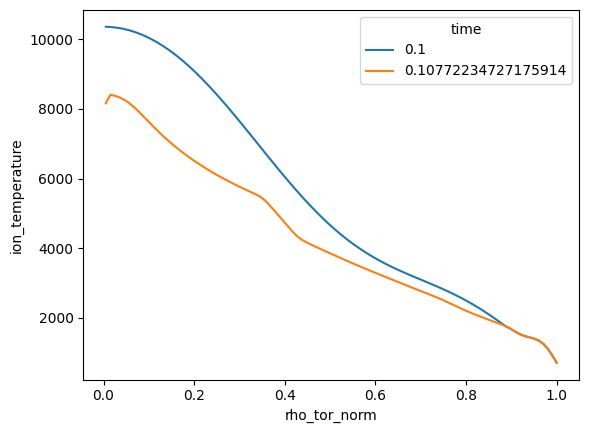

In [13]:
mean = dataset.mean(dim='run').mean(dim='ion').isel(time=[0, 1])

mean['ion_temperature'].plot.line(
    x='rho_tor_norm',
    hue='time',
)